Uncoded BPSK(4,4),Autoencoder(7,4), Hamming(7,4) MLD

In [2]:
import sionna as sn
import tensorflow as tf

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import keras
import pickle

from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Input, Dense, GaussianNoise,Lambda,Embedding,BatchNormalization,Layer
from keras import regularizers
from keras.optimizers import Adam,SGD
from keras import backend as K

In [4]:
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.linear import LinearEncoder,OSDecoder
from sionna.utils import BinarySource, ebnodb2no,sim_ber,log2,log10,hard_decisions
from sionna.utils.metrics import  count_block_errors
from sionna.channel import AWGN
from sionna.utils.plotting import PlotBER
from sionna.fec.utils import load_parity_check_examples

In [5]:
class Uncodedmodel(Model):
    def __init__(self,k,n,num_bits_per_symbol,demapping_method = 'app'):
        super().__init__()
        
        self.k = k
        self.n = n
        self.num_bits_per_symbol = num_bits_per_symbol
        self.source = BinarySource()
        self.constellation = Constellation("pam",self.num_bits_per_symbol)
        self.mapper = Mapper(constellation = self.constellation)
        self.demapper = Demapper(demapping_method,constellation = self.constellation)
        self.channel = AWGN()
        
    @tf.function()
    def call(self,batch_size,ebno_db):
        no = ebnodb2no(ebno_db,num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=self.k/self.n)  
        u = self.source([batch_size,self.k])
        x = self.mapper(u)
        y = self.channel([x,no])
        llr = self.demapper([y,no])
        return u,llr

In [6]:
# (7,4) Hamming code parity check matrix
pcm,k,n,coderate = load_parity_check_examples(pcm_id = 0)
pcm

array([[1, 0, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1]])

In [7]:
class Codedmodel(Model):
    def __init__(self,k,n,num_bits_per_symbol,pcm,demapping_method = 'app'):
        super().__init__()
        
        self.k = k
        self.n = n
        self.num_bits_per_symbol = num_bits_per_symbol
        self.source = BinarySource()
        self.constellation = Constellation("pam",self.num_bits_per_symbol)
        self.mapper = Mapper(constellation = self.constellation)
        self.demapper = Demapper(demapping_method,constellation = self.constellation)
        self.channel = AWGN()
        self.encoder = LinearEncoder(pcm,is_pcm=True)
        self.decoder = OSDecoder(encoder=self.encoder,t=2)
        
    @tf.function()
    def call(self,batch_size,ebno_db):
        
        no = ebnodb2no(ebno_db,num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=self.k/self.n)
        u = self.source([batch_size,self.k])
        c = self.encoder(u)
        x = self.mapper(c)
        y = self.channel([x,no])
        llr = self.demapper([y,no])
        u_hat = self.decoder(llr)
        
        return c,u_hat

In [9]:
# (7,4) Hamming MLD
coded_sys = Codedmodel(k = k ,n = n, pcm = pcm,num_bits_per_symbol = 1)

In [10]:
# (4,4) Uncoded BPSK
uncoded_sys = Uncodedmodel(k = 4 ,n = 4, num_bits_per_symbol = 1)

In [11]:
ebno_db = np.arange(-4, 8.5, 0.5) 

BER = {}
BLER = {}

ber,bler = sim_ber(uncoded_sys, ebno_db, soft_estimates=True,batch_size=10000, num_target_block_errors=3000, max_mc_iter=100)
BLER['uncoded'] = bler.numpy()
BER['uncoded'] = ber.numpy()

ber,bler = sim_ber(coded_sys, ebno_db, batch_size=10000, num_target_block_errors=3000, max_mc_iter=100)
BLER['coded_mld'] = bler.numpy()
BER['coded_mld'] = ber.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -4.0 | 1.8630e-01 | 5.5790e-01 |        7452 |       40000 |         5579 |       10000 |         0.8 |reached target block errors
     -3.5 | 1.7415e-01 | 5.3210e-01 |        6966 |       40000 |         5321 |       10000 |         0.0 |reached target block errors
     -3.0 | 1.5725e-01 | 4.9430e-01 |        6290 |       40000 |         4943 |       10000 |         0.0 |reached target block errors
     -2.5 | 1.4415e-01 | 4.6410e-01 |        5766 |       40000 |         4641 |       10000 |         0.0 |reached target block errors
     -2.0 | 1.3070e-01 | 4.3460e-01 |        5228 |       40000 |         4346 |       10000 |         0.0 |reached target block errors
     -1.5 | 1.1597e-01 | 3.9200e-01 |        4639 |       40000 |

In [61]:
#(7,4) Autoencoder

M = int(2**(n*coderate))
print('Number of input bits is :',k)
print('Number of possible input smybols is :',M)
print('Number of channel uses is :',n)

Number of input bits is : 4
Number of possible input smybols is : 16
Number of channel uses is : 7


In [139]:
class Encoder(Layer):
    def __init__(self,M,n):
        super().__init__()
        
        self.M = M
        self.n = n
        
        self._dense1 = Dense(self.M,'relu')
        self._dense2 = Dense(self.n, 'linear')
        self._lambda = Lambda(lambda x: np.sqrt(self.n)*K.l2_normalize(x,axis=1))
    
    def call(self,x):
        x = self._dense1(x)
        x = self._dense2(x)
        x = self._lambda(x)
        return x

In [140]:
class Decoder(Layer):
    def __init__(self,M,n):
        super().__init__()
        
        self.M = M
        self.n = n
        
        self._dense1 = Dense(self.M,'relu')
        self._dense2 = Dense(self.M, 'softmax')
    
    def call(self,y):
        y = self._dense1(y)
        y = self._dense2(y)

        return y

In [141]:
class Autoencoder(Model):
    def __init__(self, M,n,coderate,training):
        super().__init__()

        self.M = M
        self.n = n
        self.R = coderate
        self.training = training
        
        self.encoder = Encoder(self.M,self.n)
        self.decoder = Decoder(self.M,self.n)
        
        if self.training:
            self.cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    def call(self,batch_size,ebno_db):
        
        s = tf.random.uniform(shape = [batch_size],minval=0,maxval=self.M,dtype=tf.int32)
        s_onehot = tf.one_hot(s,depth=self.M)
        s_onehot = np.array(s_onehot)
        
        x = self.encoder(s_onehot)

        ebno = 10**(ebno_db/10)
        no = 1/(self.R*ebno)
        std = np.sqrt(no/2)
        noise = tf.random.normal(shape=tf.shape(x), stddev= std)

        
        y = x + noise
        y = self.decoder(y)
        
        if self.training:
            loss = self.cce(s_onehot,y)
            return loss
        else:
            s_hat = np.argmax(y,axis=1)
            return s,s_hat

In [142]:
epoch = 500
training_batch_size = tf.constant(30000, tf.int32) 

In [143]:
def training(model):
    optimizer = Adam(learning_rate=0.01)
    
    train_loss_results = []

    for i in range(epoch):
        with tf.GradientTape() as tape:
            # feedforward
            # calculate loss
            loss = model(training_batch_size,ebno_db=3) 
        weights = model.trainable_weights
        grads = tape.gradient(loss,weights)
        optimizer.apply_gradients(zip(grads, weights))

        if i % 100 == 0:
            print('Iteration {}/{}  CCE: {:.4f}'.format(i, epoch, loss.numpy()), end='\r')
            
        train_loss_results.append(loss.numpy())
    # plot loss curve
    plt.title('Loss function curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(train_loss_results,label='$Loss$')
    plt.legend
    plt.show() 

In [144]:
np.random.seed(1)
tf.random.set_seed(1)

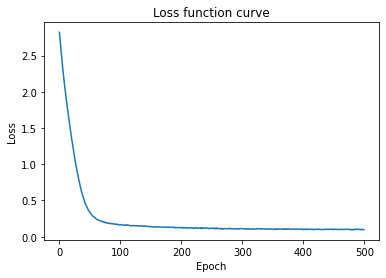

In [145]:
model_train = Autoencoder(M,n,coderate,training=True) 
training(model_train)

In [97]:
#print(model.trainable_variables)

In [146]:
weights_path_ae_74  = 'ae_74_weights'

In [147]:
weights = model_train.get_weights()
with open(weights_path_ae_74, 'wb') as f:
    pickle.dump(weights, f)

In [148]:
model_ae74 = Autoencoder(M,n,coderate,training=False)
model_ae74(tf.constant(1, tf.int32), tf.constant(10.0, tf.float32))
with open(weights_path_ae_74, 'rb') as f:
    weights = pickle.load(f)
    model_ae74.set_weights(weights)

In [149]:
ber,_ = sim_ber(model_ae74,ebno_db,batch_size=20000, num_target_bit_errors=3000, max_mc_iter=100)
BLER['ae_74'] = ber.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -4.0 | 4.9815e-01 | 1.0000e+00 |        9963 |       20000 |            1 |           1 |         0.0 |reached target bit errors
     -3.5 | 4.6245e-01 | 1.0000e+00 |        9249 |       20000 |            1 |           1 |         0.0 |reached target bit errors
     -3.0 | 4.2070e-01 | 1.0000e+00 |        8414 |       20000 |            1 |           1 |         0.0 |reached target bit errors
     -2.5 | 3.8945e-01 | 1.0000e+00 |        7789 |       20000 |            1 |           1 |         0.0 |reached target bit errors
     -2.0 | 3.4685e-01 | 1.0000e+00 |        6937 |       20000 |            1 |           1 |         0.0 |reached target bit errors
     -1.5 | 3.0210e-01 | 1.0000e+00 |        6042 |       20000 |          

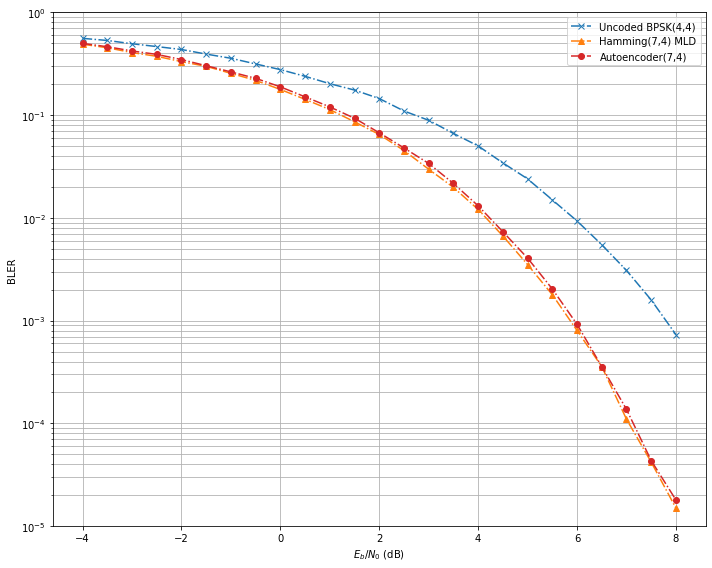

In [150]:
plt.figure(figsize=(10,8))

plt.semilogy(ebno_db, BLER['uncoded'], 'x-.', c=f'C0', label=f'Uncoded BPSK(4,4)')
plt.semilogy(ebno_db, BLER['coded_mld'], '^-.', c=f'C1', label=f'Hamming(7,4) MLD')
plt.semilogy(ebno_db, BLER['ae_74'], 'o-.', c=f'C3', label=f'Autoencoder(7,4)')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-5, 1.0))
plt.legend()
plt.tight_layout()